4422102/4422102 [==============================] - 1s 0us/step


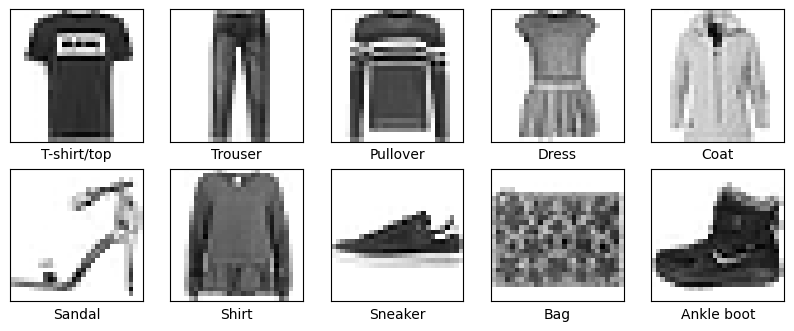

In [1]:
#importing essential libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

#loading the datasets

(x_training_set, y_training_set), (x_testing_set, y_testing_set) = fashion_mnist.load_data()

#storing different classes in a list

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#function definition to plot the one image from different classes

def plot_img(images, labels, classes):
  image_list = [] #list to store one image from each class
  class_num = len(classes)

  for i in range(class_num):
    indx = np.where(labels == i)[0][0]
    image_list.append(images[indx])

  #plotting the images

  plt.figure(figsize = (10,10))
  for i in range(class_num):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_list[i], cmap=plt.cm.binary)
    plt.xlabel(classes[i])
  plt.show()


#calling the function

plot_img(x_training_set, y_training_set, classes)

In [2]:
#splitting the data for cross validation

x_validation_set = x_training_set[50000:]
y_validation_set = y_training_set[50000:]     # validation set has 10000 data

x_training_set = x_training_set[:50000]
y_training_set = y_training_set[:50000]


#vactorising the data

x_training_set = x_training_set.reshape(x_training_set.shape[0], 784)  #28x28 pixels = 784
x_testing_set = x_testing_set.reshape(x_testing_set.shape[0], 784)
x_validation_set = x_validation_set.reshape(x_validation_set.shape[0], 784)

#normalising the data

x_train = x_training_set/255  # since, pixel range from 0 to 255
x_test = x_testing_set/255
x_valid = x_validation_set/255

#one hot encoding for labels to represent categorical variables as numerical values

y_train = to_categorical(y_training_set)
y_test = to_categorical(y_testing_set)
y_valid = to_categorical(y_validation_set)


#default_x_train = x_train
#default_y_train = y_train

# some useful functions

#for hidden layer
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return (x>0)*(x)

def tanh(x):
  return np.tanh(x)

def gradient_sigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

def gradient_tanh(x):
  return 1 - np.tanh(x) ** 2

def gradient_relu(x):
  return np.where(x > 0, 1, 0)

#for output layer
def softmax(x):
  exponents = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exponents / np.sum(exponents, axis=1, keepdims=True)


#loss function(cross-entropy)
def loss_func(x,y):
  L = -np.mean(np.sum(x * np.log(y), axis=1))
  return L


#function to choose the activation functions

def choose_activation(x, activation_function):
  if activation_function == 'sigmoid':
    return sigmoid(x)

  elif activation_function == 'tanh':
    return tanh(x)

  elif activation_function == 'relu':
    return relu(x)


#function for derivatives

def activation_derivative(x, activation_function):
    if activation_function == 'sigmoid':
        return gradient_sigmoid(x)
    elif activation_function == 'relu':
        return gradient_relu(x)
    elif activation_function == 'tanh':
        return gradient_tanh(x)
    else:
        raise ValueError("Invalid activation function. Please choose from 'sigmoid', 'relu', or 'tanh'.")

In [3]:
#class definition

class Network:
    def __init__(self, neuron_sizes, weight_initialiser, activation_function, momentum, beta1, beta2):

        self.train_loss_sgd = []
        self.train_loss_momentum = []


        self.total_layers = len(neuron_sizes)
        self.momentum = momentum
        #self.weight_initialiser = weight_initialiser
        self.activation_function = activation_function
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = 1e-8

        # Initializing the weights and biases
        # After initializing, store weights and biases in separate lists
        if weight_initialiser == 'xavier':
            if activation_function != 'relu':
                self.Weights = [-1/np.sqrt(neuron_sizes[i])+np.random.randn(neuron_sizes[i], neuron_sizes[i+1])*2/np.sqrt(neuron_sizes[i]) for i in range(self.total_layers-1)]
                self.biases = [-1/np.sqrt(neuron_sizes[i])+np.random.randn(1, neuron_sizes[i+1])*2/np.sqrt(neuron_sizes[i]) for i in range(self.total_layers-1)]
            else:
                self.Weights = [np.random.randn(neuron_sizes[i], neuron_sizes[i+1])*(np.sqrt(2/(neuron_sizes[i]))) for i in range(self.total_layers-1)]
                self.biases = [np.random.randn(1, neuron_sizes[i+1])*(np.sqrt(2/(neuron_sizes[i]))) for i in range(self.total_layers-1)]
        else:
            self.Weights = [np.random.randn(neuron_sizes[i], neuron_sizes[i+1]) for i in range(self.total_layers-1)]
            self.biases = [np.random.randn(1, neuron_sizes[i+1])*0.05 for i in range(self.total_layers-1)]

        # Initializing momentum weights and biases
        self.Weights_moment = [np.zeros_like(x) for x in self.Weights]
        self.biases_moment = [np.zeros_like(x) for x in self.biases]

        # Initializing Nesterov momentum adjusted weights and biases
        self.momentum_adjusted_Weights = None
        self.momentum_adjusted_biases = None


        # Initializing for adam optimizer
        self.Weights_moment_adam1 = [np.zeros_like(x) for x in self.Weights]
        self.biases_moment_adam1 = [np.zeros_like(x) for x in self.biases]
        self.Weights_moment_adam2 = [np.zeros_like(x) for x in self.Weights]  #rmsprop
        self.biases_moment_adam2 = [np.zeros_like(x) for x in self.biases]   #rmsprop



    # Defining function for forward propagation
    def forward_prop(self, X):
        self.pre_activations_A = [None]*(self.total_layers)  # List to store the pre-activations
        self.activations_H = [X]  # List to store the activations

        for i in range(self.total_layers-1):
            self.pre_activations_A[i+1] = np.dot(self.activations_H[i], self.Weights[i]) + self.biases[i]
            if i == self.total_layers-2:  # For output layer: activation function = softmax
                h = softmax(self.pre_activations_A[i+1])
                self.activations_H.append(h)
            else:  # For hidden layers: activation function = sigmoid
                h = choose_activation(self.pre_activations_A[i+1], self.activation_function)
                #h = sigmoid(self.pre_activations_A[i+1])
                self.activations_H.append(h)
        return self.activations_H[-1]

    #defining the training method for stochastic gradient method
    def train_sgd(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            loss_epo = 0
            for i in range(0, x_train.shape[0], batch_size):
                # Forward pass
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]
                y_predicted = self.forward_prop(Xbatch)

                #calculate loss
                loss = loss_func(Ybatch, y_predicted)
                loss_epo = loss_epo+loss

                # Applying backpropagation algorithm
                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        derivative_activation = activation_derivative(self.pre_activations_A[j-1], self.activation_function)
                        loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T) * derivative_activation
                        #loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    #updation of parameters
                    self.Weights[j-1] = self.Weights[j-1] - learning_rate_eta * gradient_W
                    self.biases[j-1] = self.biases[j-1] - learning_rate_eta * gradient_b

            #computing average epoch loss
            loss_epo = loss_epo / (x_train.shape[0] / batch_size)
            self.train_loss_sgd.append(loss_epo)

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')
            #wandb.log({'val-accuracy':valid_accuracy*100})


        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')

    # Defining the momentum-based gradient descent training method
    def train_momentum(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            loss_epo = 0
            for i in range(0, x_train.shape[0], batch_size):

                #performing the forward pass
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]
                y_predicted = self.forward_prop(Xbatch)

                #calculate loss
                loss = loss_func(Ybatch, y_predicted)
                loss_epo = loss_epo+loss

                #performing the back-propagation
                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        derivative_activation = activation_derivative(self.pre_activations_A[j-1], self.activation_function)
                        loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T) * derivative_activation
                        #loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    #updation of momentum
                    self.Weights_moment[j-1] = self.momentum * self.Weights_moment[j-1] + learning_rate_eta * gradient_W
                    self.biases_moment[j-1] = self.momentum * self.biases_moment[j-1] + learning_rate_eta * gradient_b

                    #updation of parameters
                    self.Weights[j-1] = self.Weights[j-1] - self.Weights_moment[j-1]
                    self.biases[j-1] = self.biases[j-1] - self.biases_moment[j-1]

            #computing average epoch loss
            loss_epo = loss_epo / (x_train.shape[0] / batch_size)
            self.train_loss_momentum.append(loss_epo)

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')
            #wandb.log({'val-accuracy':valid_accuracy*100})

        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')

    #defining the training method for nesterov accelerated gradient descent method
    def train_nag(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            for i in range(0, x_train.shape[0], batch_size):
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]

                # Nesterov accelerated gradient descent: lookahead
                '''
                self.momentum_adjusted_Weights = [self.Weights[j-1] - self.momentum * self.Weights_moment[j-1] for j in range(self.total_layers - 1, 0, -1)]
                self.momentum_adjusted_biases = [self.biases[j-1] - self.momentum * self.biases_moment[j-1] for j in range(self.total_layers - 1, 0, -1)]'''

                self.momentum_adjusted_Weights = [self.Weights[j] - self.momentum * self.Weights_moment[j] for j in range(self.total_layers-1)]
                self.momentum_adjusted_biases = [self.biases[j] - self.momentum * self.biases_moment[j] for j in range(self.total_layers-1)]
                '''
                print(self.momentum_adjusted_Weights[-1].shape)
                print(self.momentum_adjusted_Weights[-2].shape)
                print(self.momentum_adjusted_Weights[-3].shape)'''

                y_predicted = self.forward_prop(Xbatch)

                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        #derivative_activation = 1 - self.activations_H[j-1] ** 2
                        derivative_activation = activation_derivative(self.pre_activations_A[j-1], self.activation_function)
                        loss_gradient = np.dot(loss_gradient, self.momentum_adjusted_Weights[j-1].T) * derivative_activation

                        #loss_gradient = np.dot(loss_gradient, self.momentum_adjusted_Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    self.Weights[j-1] = self.momentum_adjusted_Weights[j-1] - learning_rate_eta * gradient_W
                    self.biases[j-1] = self.momentum_adjusted_biases[j-1] - learning_rate_eta * gradient_b

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')
            #wandb.log({'val-accuracy':valid_accuracy*100})
            #wandb.log({'epoch':epoch+1})

        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')



    def train_adam(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
      for epoch in range(total_epochs):
        loss_epo = 0
        for i in range(0, x_train.shape[0], batch_size):
          Xbatch = x_train[i:i+batch_size]
          Ybatch = y_train[i:i+batch_size]
          y_predicted = self.forward_prop(Xbatch)

          #calculate loss
          loss = loss_func(Ybatch, y_predicted)
          loss_epo = loss_epo + loss

          #backpropagation
          loss_gradient = y_predicted-Ybatch
          for j in range(self.total_layers-1, 0, -1):
            gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
            gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)

            if j > 1:
              derivative_activation = activation_derivative(self.pre_activations_A[j-1], self.activation_function)
              loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T)*derivative_activation

            #compute 1st momentum term
            self.Weights_moment_adam1[j-1] = self.beta1 * self.Weights_moment_adam1[j-1] + (1-self.beta1) * gradient_W
            self.biases_moment_adam1[j-1] = self.beta1 * self.biases_moment_adam1[j-1] + (1-self.beta1) * gradient_b

            #compute 2nd moment term
            self.Weights_moment_adam2[j-1] = self.beta2 * self.Weights_moment_adam2[j-1] + (1-self.beta2) * np.square(gradient_W)
            self.biases_moment_adam2[j-1] = self.beta2 * self.biases_moment_adam2[j-1] + (1-self.beta2) * np.square(gradient_b)

            #corrected terms in 1st moment
            corrected_weight_adam1 = self.Weights_moment_adam1[j-1] / (1-self.beta1 ** (epoch+1))
            corrected_bias_adam1 = self.biases_moment_adam1[j-1] / (1-self.beta1 ** (epoch+1))

            #corrected terms in 2nd moment
            corrected_weight_adam2 = self.Weights_moment_adam2[j-1] / (1-self.beta2 ** (epoch+1))
            corrected_bias_adam2 = self.biases_moment_adam2[j-1] / (1-self.beta2 ** (epoch+1))

            #updating weights and biases
            self.Weights[j-1] = self.Weights[j-1] - learning_rate_eta * corrected_weight_adam1 / (np.sqrt(corrected_weight_adam2)+self.epsilon)
            self.biases[j-1] = self.biases[j-1] - learning_rate_eta * corrected_bias_adam1 / (np.sqrt(corrected_bias_adam2)+self.epsilon)

        #computing accuracy on validation set
        y_valid_predicted = self.forward_prop(x_valid)
        valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
        print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')
        wandb.log({'val-accuracy':valid_accuracy*100})
        wandb.log({'epoch':epoch+1})

      #checking the efficiency of the model by passing test set
      y_test_predicted = self.forward_prop(x_test)
      test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
      print(f'Test Accuracy: {test_accuracy:.4f}')





In [4]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [5]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [6]:
wandb.login(key='cd7a6c2259e8886dc269bbf6f0f9e55089d3beeb')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
# You need to define a config file in the form of dictionary or yaml
sweep_config = {
    'method': 'grid',
    'name' : 'sweep test',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers':{
            'values':[3,4,5]
        },
        'optimizer': {
            'values':['adam']
        },
         'hidden_size':{
            'values':[32,64,128]
        },
        'batch_size': {
            'values':[16,32,64]
        },
        'learning_rate': {
            'values':[1e-3, 1e-4]
        },
        'weight_init': {
           'values' :['random', 'xavier']
        },
        'activation': {
            'values': ['relu','tanh']
        },
        'loss': {
            'values': ['cross_entropy']
        },


    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='Deep_Learning_Assignment1')

Create sweep with ID: xsggxwuw
Sweep URL: https://wandb.ai/prabhat-kumar/Deep_Learning_Assignment1/sweeps/xsggxwuw


In [8]:
def main():
    '''
    WandB calls main function each time with differnet combination.

    We can retrive the same and use the same values for our hypermeters.

    '''


    with wandb.init(entity = 'prabhat-kumar') as run:

        run_name="-ac_"+wandb.config.activation+"-hs"+str(wandb.config.hidden_size)+'-wi'+wandb.config.weight_init+'-hl'+str(wandb.config.hidden_layers)+'-op'+wandb.config.optimizer+'-ep'+str(wandb.config.epochs)+'lr'+str(wandb.config.learning_rate)+'bs'+str(wandb.config.batch_size)
        wandb.run.name=run_name
        #obj=NN(wandb.config['num_layers'],wandb.config['hidden_size'])

        model = Network([784,wandb.config.hidden_size,10], wandb.config.weight_init, wandb.config.activation, 0.9, 0.9, 0.999)

        if wandb.config.optimizer == 'nestrov':
          model.train_nag(x_train, y_train, wandb.config.learning_rate, wandb.config.epochs, wandb.config.batch_size)
        if wandb.config.optimizer == 'momentum':
          model.train_momentum(x_train, y_train, wandb.config.learning_rate, wandb.config.epochs, wandb.config.batch_size)
        if wandb.config.optimizer == 'sgd':
          model.train_sgd(x_train, y_train, wandb.config.learning_rate, wandb.config.epochs, wandb.config.batch_size)
        if wandb.config.optimizer == 'adam':
          model.train_adam(x_train, y_train, wandb.config.learning_rate, wandb.config.epochs, wandb.config.batch_size)
        #model.train_momentum(x_train, y_train, 0.01, 30, 128)
        #criterion = nn.CrossEntropyLoss()
        #optimizer = optim.Adam(model.parameters(), lr=0.01,betas=(0.9, 0.999))
        #model.train( model,criterion,optimizer,x_train,y_train,x_val,y_val)


wandb.agent(sweep_id, function=main,count=5) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: 660t3uol with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: Currently logged in as: prabhat-kumar. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch Number 1, validation accuracy: 0.5518
Epoch Number 2, validation accuracy: 0.6350
Epoch Number 3, validation accuracy: 0.6548
Epoch Number 4, validation accuracy: 0.6704
Epoch Number 5, validation accuracy: 0.6794
Test Accuracy: 0.6792


epoch,▁▃▅▆█
val-accuracy,▁▆▇██
epoch,5
val-accuracy,67.94


wandb: Agent Starting Run: 8hwg6wou with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch Number 1, validation accuracy: 0.8329
Epoch Number 2, validation accuracy: 0.8456
Epoch Number 3, validation accuracy: 0.8511
Epoch Number 4, validation accuracy: 0.8585
Epoch Number 5, validation accuracy: 0.8614
Test Accuracy: 0.8549


epoch,▁▃▅▆█
val-accuracy,▁▄▅▇█
epoch,5
val-accuracy,86.14


wandb: Agent Starting Run: 27m6m9xj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch Number 1, validation accuracy: 0.2885
Epoch Number 2, validation accuracy: 0.3913
Epoch Number 3, validation accuracy: 0.4554
Epoch Number 4, validation accuracy: 0.4941
Epoch Number 5, validation accuracy: 0.5223
Test Accuracy: 0.5083


epoch,▁▃▅▆█
val-accuracy,▁▄▆▇█
epoch,5
val-accuracy,52.23


wandb: Agent Starting Run: 2y6skrnn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch Number 1, validation accuracy: 0.7665
Epoch Number 2, validation accuracy: 0.7906
Epoch Number 3, validation accuracy: 0.8035
Epoch Number 4, validation accuracy: 0.8115
Epoch Number 5, validation accuracy: 0.8177
Test Accuracy: 0.8087


epoch,▁▃▅▆█
val-accuracy,▁▄▆▇█
epoch,5
val-accuracy,81.77


wandb: Agent Starting Run: bnsc477z with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch Number 1, validation accuracy: 0.6889
Epoch Number 2, validation accuracy: 0.7145
Epoch Number 3, validation accuracy: 0.7327
Epoch Number 4, validation accuracy: 0.7421
Epoch Number 5, validation accuracy: 0.7470
Test Accuracy: 0.7531


epoch,▁▃▅▆█
val-accuracy,▁▄▆▇█
epoch,5
val-accuracy,74.7
